In [56]:
import os
import torch
from torch import nn
from unidecode import unidecode  # standardize all characters
from string import ascii_letters
import random  # split train and test samples
from tqdm import tqdm # nice bars showing training progress
import matplotlib.pyplot as plt

# Read data

In [57]:
# read different languages and number them in sequence
data_dir = "./rnn_data/names"
# assign a unique index to each file (language)
lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}
num_langs = len(lang2label)

lang2label

{'Czech': tensor([0]),
 'German': tensor([1]),
 'Arabic': tensor([2]),
 'Japanese': tensor([3]),
 'Chinese': tensor([4]),
 'Vietnamese': tensor([5]),
 'Russian': tensor([6]),
 'French': tensor([7]),
 'Irish': tensor([8]),
 'English': tensor([9]),
 'Spanish': tensor([10]),
 'Greek': tensor([11]),
 'Italian': tensor([12]),
 'Portuguese': tensor([13]),
 'Scottish': tensor([14]),
 'Dutch': tensor([15]),
 'Korean': tensor([16]),
 'Polish': tensor([17])}

In [58]:
# Create a dictionary mapping each character to a unique index.
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}
num_letters = len(char2idx)
char2idx

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'X': 49,
 'Y': 50,
 'Z': 51,
 ' ': 52,
 '.': 53,
 ',': 54,
 ':': 55,
 ';': 56,
 '-': 57,
 "'": 58}

In [59]:
# use one-hot embedding to encode each character
def name2tensor(name):
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, char in enumerate(name):
        tensor[i][0][char2idx[char]] = 1
    return tensor

In [60]:
# Initialize lists to store the one-hot encoded name tensors and their corresponding language labels
tensor_names = []
target_langs = []

# Iterate over each file in the specified data directory
# Each file is assumed to contain names from a specific language
for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file)) as f:
        lang = file.split(".")[0]  # read the filename without .txt
        names = [unidecode(line.rstrip()) for line in f]  # read the standardized texts in the file
        for name in names:
            try:
                tensor_names.append(name2tensor(name))  # use one-hot encoding to embed each word in the file, add to input
                target_langs.append(lang2label[lang])  # use number to indicate which language the input is, add to output
            except KeyError:
                pass

In [61]:
# sample index for training set and test set
train_idx = random.sample(range(len(target_langs)), round(len(target_langs)*0.9))
test_idx = [x for x in range(len(target_langs)) if x not in train_idx]

# construct training set
train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

# construct test set
test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

# Define the model architecture

In [62]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)   # both input and hidden state go into the layer
        self.in2output = nn.Linear(input_size + hidden_size, output_size)   # both input and hidden state go into the layer
    
    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [80]:
# model
model = MyRNN(input_size=num_letters, hidden_size=256, output_size=num_langs)
# loss functions
criterion = nn.CrossEntropyLoss()
# Use Adam to update parameters
optimizer = torch.optim.Adam(model.parameters())

# Training 

In [ ]:
print_interval = 3000
num_epoch = 10

train_loss, train_acc = [], []
for epoch in range(num_epoch):
    epoch_loss, correct = 0, 0
    for i, (name, label) in enumerate(tqdm(train_dataset)):
        optimizer.zero_grad()
        hidden_state = model.init_hidden()  # Initialize the hidden state
        for char in name:
            output, hidden_state = model(char, hidden_state) # Pass the character and the current hidden state
        loss = criterion(output, label)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1) # clip the gradient to promote convergence
        optimizer.step()
        
        epoch_loss += loss.item()
        _, pred = torch.max(output, dim=1)
        correct += bool(pred == label)

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epoch}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )
        
    train_loss.append(epoch_loss / len(train_dataset))
    train_acc.append(correct / len(train_dataset))

 17%|█▋        | 3013/18063 [00:21<02:17, 109.62it/s]

Epoch [1/10], Step [3000/18063], Loss: 0.0058


 33%|███▎      | 6028/18063 [00:43<01:18, 153.50it/s]

Epoch [1/10], Step [6000/18063], Loss: 2.8031


 50%|████▉     | 9028/18063 [01:04<01:01, 146.24it/s]

Epoch [1/10], Step [9000/18063], Loss: 0.0258


 66%|██████▋   | 12007/18063 [01:23<00:37, 160.21it/s]

Epoch [1/10], Step [12000/18063], Loss: 1.7620


 83%|████████▎ | 15011/18063 [01:44<00:21, 141.92it/s]

Epoch [1/10], Step [15000/18063], Loss: 5.5142


100%|█████████▉| 18014/18063 [02:04<00:00, 131.59it/s]

Epoch [1/10], Step [18000/18063], Loss: 0.0713


 17%|█▋        | 3010/18063 [00:20<01:44, 143.78it/s]

Epoch [2/10], Step [3000/18063], Loss: 0.0014


 33%|███▎      | 6021/18063 [00:45<01:43, 116.75it/s]

Epoch [2/10], Step [6000/18063], Loss: 0.6396


 50%|████▉     | 9031/18063 [01:04<00:53, 169.04it/s]

Epoch [2/10], Step [9000/18063], Loss: 0.0010


 67%|██████▋   | 12015/18063 [01:23<00:42, 143.62it/s]

Epoch [2/10], Step [12000/18063], Loss: 0.6446


 83%|████████▎ | 15026/18063 [01:41<00:16, 186.96it/s]

Epoch [2/10], Step [15000/18063], Loss: 6.2663


100%|█████████▉| 18035/18063 [02:01<00:00, 173.80it/s]

Epoch [2/10], Step [18000/18063], Loss: 0.1182


 17%|█▋        | 3007/18063 [00:22<02:11, 114.92it/s]

Epoch [3/10], Step [3000/18063], Loss: 0.0016


 33%|███▎      | 6021/18063 [00:45<01:30, 133.57it/s]

Epoch [3/10], Step [6000/18063], Loss: 0.3253


 50%|████▉     | 9024/18063 [01:08<01:03, 142.54it/s]

Epoch [3/10], Step [9000/18063], Loss: 0.0002


 67%|██████▋   | 12022/18063 [01:30<00:35, 172.39it/s]

Epoch [3/10], Step [12000/18063], Loss: 0.3305


 83%|████████▎ | 15018/18063 [01:51<00:19, 159.63it/s]

Epoch [3/10], Step [15000/18063], Loss: 6.7000


100%|█████████▉| 18033/18063 [02:13<00:00, 150.11it/s]

Epoch [3/10], Step [18000/18063], Loss: 0.0694


 17%|█▋        | 3010/18063 [00:24<02:17, 109.84it/s]

Epoch [4/10], Step [3000/18063], Loss: 0.0013


 33%|███▎      | 6024/18063 [00:46<01:26, 138.79it/s]

Epoch [4/10], Step [6000/18063], Loss: 0.2464


 50%|████▉     | 9015/18063 [01:08<01:33, 96.62it/s] 

Epoch [4/10], Step [9000/18063], Loss: 0.0001


 67%|██████▋   | 12027/18063 [01:32<00:36, 163.17it/s]

Epoch [4/10], Step [12000/18063], Loss: 0.0528


 83%|████████▎ | 15008/18063 [01:52<00:25, 118.81it/s]

Epoch [4/10], Step [15000/18063], Loss: 5.6333


100%|█████████▉| 18037/18063 [02:12<00:00, 169.77it/s]

Epoch [4/10], Step [18000/18063], Loss: 0.0687


 17%|█▋        | 3023/18063 [00:19<01:29, 168.39it/s]

Epoch [5/10], Step [3000/18063], Loss: 0.0009


 33%|███▎      | 6028/18063 [00:37<01:08, 176.42it/s]

Epoch [5/10], Step [6000/18063], Loss: 0.2012


 50%|████▉     | 9017/18063 [00:56<01:04, 140.19it/s]

Epoch [5/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12019/18063 [01:16<00:37, 161.80it/s]

Epoch [5/10], Step [12000/18063], Loss: 0.2078


 83%|████████▎ | 15024/18063 [01:37<00:24, 125.62it/s]

Epoch [5/10], Step [15000/18063], Loss: 6.1484


100%|█████████▉| 18019/18063 [01:59<00:00, 132.32it/s]

Epoch [5/10], Step [18000/18063], Loss: 0.0483


 17%|█▋        | 3019/18063 [00:23<02:18, 108.55it/s]

Epoch [6/10], Step [3000/18063], Loss: 0.0006


 33%|███▎      | 6010/18063 [00:48<01:40, 120.48it/s]

Epoch [6/10], Step [6000/18063], Loss: 0.3352


 50%|████▉     | 9015/18063 [01:16<01:29, 100.93it/s]

Epoch [6/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12012/18063 [01:39<00:50, 119.63it/s]

Epoch [6/10], Step [12000/18063], Loss: 0.3800


 83%|████████▎ | 15021/18063 [02:03<00:23, 128.02it/s]

Epoch [6/10], Step [15000/18063], Loss: 5.1432


100%|█████████▉| 18022/18063 [02:26<00:00, 106.67it/s]

Epoch [6/10], Step [18000/18063], Loss: 0.0540


 17%|█▋        | 3011/18063 [00:22<01:37, 155.03it/s]

Epoch [7/10], Step [3000/18063], Loss: 0.0006


 33%|███▎      | 6021/18063 [00:45<01:32, 130.82it/s]

Epoch [7/10], Step [6000/18063], Loss: 0.1720


 50%|████▉     | 9024/18063 [01:08<01:09, 130.34it/s]

Epoch [7/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12027/18063 [01:29<00:41, 144.78it/s]

Epoch [7/10], Step [12000/18063], Loss: 0.5242


 83%|████████▎ | 15025/18063 [01:52<00:21, 143.43it/s]

Epoch [7/10], Step [15000/18063], Loss: 4.3351


100%|█████████▉| 18022/18063 [02:15<00:00, 129.16it/s]

Epoch [7/10], Step [18000/18063], Loss: 0.0523


 17%|█▋        | 3022/18063 [00:23<01:58, 126.95it/s]

Epoch [8/10], Step [3000/18063], Loss: 0.0005


 33%|███▎      | 6014/18063 [00:48<01:37, 123.46it/s]

Epoch [8/10], Step [6000/18063], Loss: 0.2110


 50%|████▉     | 9022/18063 [01:10<01:03, 143.33it/s]

Epoch [8/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12027/18063 [01:34<00:45, 134.03it/s]

Epoch [8/10], Step [12000/18063], Loss: 0.1620


 83%|████████▎ | 15022/18063 [01:57<00:24, 125.52it/s]

Epoch [8/10], Step [15000/18063], Loss: 4.1219


100%|█████████▉| 18011/18063 [02:20<00:00, 128.36it/s]

Epoch [8/10], Step [18000/18063], Loss: 0.0970


 17%|█▋        | 3010/18063 [00:22<01:54, 131.64it/s]

Epoch [9/10], Step [3000/18063], Loss: 0.0001


 33%|███▎      | 6024/18063 [00:48<01:38, 122.57it/s]

Epoch [9/10], Step [6000/18063], Loss: 0.0542


 50%|█████     | 9032/18063 [01:12<00:58, 154.34it/s]

Epoch [9/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12024/18063 [01:35<00:43, 137.96it/s]

Epoch [9/10], Step [12000/18063], Loss: 0.0086


 83%|████████▎ | 15008/18063 [01:58<00:20, 147.52it/s]

Epoch [9/10], Step [15000/18063], Loss: 3.0844


100%|█████████▉| 18019/18063 [02:21<00:00, 125.53it/s]

Epoch [9/10], Step [18000/18063], Loss: 0.1155


 17%|█▋        | 3018/18063 [00:23<01:38, 153.32it/s]

Epoch [10/10], Step [3000/18063], Loss: 0.0000


 33%|███▎      | 6024/18063 [00:47<01:45, 114.46it/s]

Epoch [10/10], Step [6000/18063], Loss: 0.0312


 50%|████▉     | 9014/18063 [01:10<01:12, 124.32it/s]

Epoch [10/10], Step [9000/18063], Loss: 0.0000


 67%|██████▋   | 12018/18063 [01:33<00:51, 117.57it/s]

Epoch [10/10], Step [12000/18063], Loss: 0.0019


 83%|████████▎ | 15028/18063 [01:57<00:22, 132.86it/s]

Epoch [10/10], Step [15000/18063], Loss: 3.5097


100%|█████████▉| 18015/18063 [02:21<00:00, 123.25it/s]

Epoch [10/10], Step [18000/18063], Loss: 0.0407


100%|██████████| 18063/18063 [02:21<00:00, 127.75it/s]


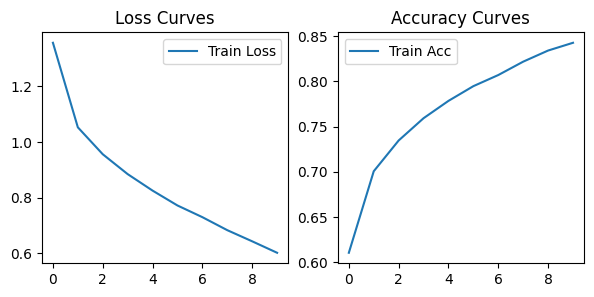

In [ ]:
# visualize the loss 
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.title('Loss Curves')
plt.legend()

# visualize the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Evaluation

In [90]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 79.6712%


Reference:

https://jaketae.github.io/study/pytorch-rnn/